In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
dt = 0.1
run_time = 100

initial_state = np.array([[0], 
                        [0], 
                        [0]])

initial_model_uncertainty = np.zeros(shape=(3,3))


U = np.array([[0.5, 0], 
              [0, np.deg2rad(5)]])


actual_r = np.array([[0.5, 0, 0], 
                     [0, 0.5 ,0],
                     [0, 0 ,0.5]])


ekf_q = np.array([[0.3, 0, 0], 
                  [0, 0.3 , 0], 
                  [0,0, 0.3]])


ekf_r = np.array([[1, 0, 0], 
                  [0, 1 ,0],
                  [0, 0 ,1]])


aekf_sigma_n_avg = 0.1
aekf_sigma_v_avg = np.array([[0.5],
                             [0.5],
                             [0.5]])

aekf_sigma_n_ests = [aekf_sigma_n_avg]                             
aekf_sigma_v_ests = [aekf_sigma_v_avg]                             


l_n_counter = 0
l_v_counter = 0


In [3]:
def actual_next_state(prev_state, u):

    v = u[0][0]
    w = u[1][0]


    theta_d = prev_state[2][0] +w*dt


    b = np.array([[dt*np.cos(theta_d), 0],
                 [dt*np.sin(theta_d), 0],
                 [0, dt]])


    next_state = prev_state + b@u
    return next_state



Prediction function returning current prior state estimate and current prior model covariance matrix

In [4]:
def ekf_predict(robot_state, robot_input, prev_post_p):


    v = robot_input[0][0]
    w = robot_input[1][0]
    theta_d = robot_state[2][0] +w*dt/2


    A_d = np.array([[1, 0, -0.5*v*(dt**2)*np.sin(theta_d)],
                    [0, 1, 0.5*v*(dt**2)*np.cos(theta_d)],
                    [0, 0, dt]])

    Q_d = np.array([[(dt + (v**2)*(dt**3)*(np.sin(theta_d)**2)/3)*ekf_q[0][0], -(v**2)*(dt**3)*np.cos(theta_d)*np.sin(theta_d)/3, -(v)*(dt*2)*np.sin(theta_d)/2],
                    [-(v**2)*(dt**3)*np.cos(theta_d)*np.sin(theta_d)/3, (dt + (v**2)*(dt**3)*(np.sin(theta_d)**2)/3)*ekf_q[1][1], (v)*(dt*2)*np.cos(theta_d)/2],
                    [-(v)*(dt*2)*np.sin(theta_d)/2, (v)*(dt*2)*np.cos(theta_d)/2, dt*ekf_q[2][2]]])



    L = np.array([[np.cos(theta_d), -0.5*v*(dt**2)*np.sin(theta_d)],
                  [np.sin(theta_d), 0.5*v*(dt**2)*np.cos(theta_d)],
                  [0, dt]])

    new_prior_state_est = robot_state + L@robot_input
    new_prior_p = A_d@prev_post_p@(A_d.T)+Q_d+ekf_q

    # b = np.array([[np.cos(theta_d)*dt,0],
    #               [np.sin(theta_d)*dt,0], 
    #               [0, dt]])

    # new_prior_state_est = robot_state + b@robot_input
    # new_prior_p = A_d@prev_post_p@(A_d.T)+L@U@(L.T)+q

    return new_prior_state_est, new_prior_p

Innovation function correcting the prior state estimates and prior model covariance matrices using a measurement function representing gps data of the absolute location of the robot

In [5]:
def ekf_innovate(prior_state_est, new_prior_p, Z):

    # here new prior p is the value we expect to see from the gps
    model_and_measurment_cov = new_prior_p + ekf_r
    K = new_prior_p@np.linalg.inv(model_and_measurment_cov)

    post_state_est = prior_state_est + K@(Z-prior_state_est)
    post_p = [np.eye(3)-K]@new_prior_p

    return post_state_est, post_p[0]

In [6]:
def ekf(prev_post_state, robot_input, prev_post_p,Z):
    
    new_prior_state, new_prior_p = ekf_predict(prev_post_state, robot_input, prev_post_p)
    return ekf_innovate(new_prior_state, new_prior_p, Z)


In [7]:
def aekf(robot_state, robot_input, prev_post_p, Z, aekf_sigma_n_avg, aekf_sigma_n_ests, aekf_sigma_v_avg, l_n, l_n_counter):

    v = robot_input[0][0]
    w = robot_input[1][0]
    theta_d = robot_state[2][0] +w*dt/2


    A_d = np.array([[1, 0, -0.5*v*(dt**2)*np.sin(theta_d)],
                    [0, 1, 0.5*v*(dt**2)*np.cos(theta_d)],
                    [0, 0, dt]])

    q_bar = np.array([[(dt + (v**2)*(dt**3)*(np.sin(theta_d)**2)/3), -(v**2)*(dt**3)*np.cos(theta_d)*np.sin(theta_d)/3, -(v)*(dt*2)*np.sin(theta_d)/2],
                    [-(v**2)*(dt**3)*np.cos(theta_d)*np.sin(theta_d)/3, (dt + (v**2)*(dt**3)*(np.sin(theta_d)**2)/3), (v)*(dt*2)*np.cos(theta_d)/2],
                    [-(v)*(dt*2)*np.sin(theta_d)/2, (v)*(dt*2)*np.cos(theta_d)/2, dt]])

    Q_d = deepcopy(q_bar)
    Q_d[0][0] = Q_d[0][0]*aekf_sigma_n_avg
    Q_d[1][1] = Q_d[1][1]*aekf_sigma_n_avg
    Q_d[2][2] = Q_d[2][2]*aekf_sigma_n_avg


    L = np.array([[np.cos(theta_d), -0.5*v*(dt**2)*np.sin(theta_d)],
                  [np.sin(theta_d), 0.5*v*(dt**2)*np.cos(theta_d)],
                  [0, dt]])

    C = np.eye(3)

    new_prior_est = robot_state + L@robot_input
    new_prior_p = A_d@prev_post_p@(A_d.T)+Q_d+aekf_sigma_n_avg*np.eye(3)


    #start correction process
    model_and_measurement_cov = new_prior_p + ekf_r
    K = new_prior_p@np.linalg.inv(model_and_measurement_cov)
    # models the difference in the actual measurement versus the predicted measurement
    # predicted estimate is just the prior state estimate since its gps data
    residual = Z-new_prior_est 
    post_state_est = new_prior_est + K@residual
    post_p = [np.identity(3)-K]@new_prior_p


    # calculates new sigma_n_est
    def get_sigma_n_est():
        sigma_n_est = np.zeros(shape = (3, 1), dtype = object)
        for i in range(0,3):
            sigma_n_i_est = (residual[i][0]**2 - C[i]@A_d@prev_post_p@(A_d.T)@(C[i].T) - aekf_sigma_v_avg[i][0])/(C[i]@q_bar@(C[i].T))
            sigma_n_est[i] = max(sigma_n_i_est, 0)

        # print(sigma_n_est)
        aekf_sigma_n_ests.append(sigma_n_est)

    get_sigma_n_est()

    if l_n_counter == l_n:

        cummulative_estimate = np.array([[0], [0], [0]], dtype = object)
        for i in range(min(len(aekf_sigma_n_ests), l_n)):
            cummulative_estimate += aekf_sigma_n_ests[-i]
        
        sigma_n_total = 0
        for i in range(3):
            sigma_n_total += cummulative_estimate[i][0]

        sigma_n_total = sigma_n_total/3
        
        aekf_sigma_n_avg = sigma_n_total/l_n
        l_n_counter =0

    l_n_counter += 1

    return post_state_est, post_p[0], aekf_sigma_n_avg, l_n_counter

In [8]:
def make_noisy(means, covariances):

    n = len(means)

    noisy_values = np.zeros(shape = (n, 1))
    for i in range(n):
        noisy_values[i][0] = means[i][0] + np.random.normal(0, covariances[i][i])

    return noisy_values


In [9]:
def get_avg_error(true_x, true_y, est_x, est_y):
    
    error_distance = []
    for i in range(len(true_x)):
        delta_x = true_x[i] - est_x[i]
        delta_y = true_y[i] - est_y[i]

        dist = np.sqrt(delta_x**2 + delta_y**2)
        error_distance.append(dist)

    avg_error = sum(error_distance)/len(error_distance)
    return avg_error

In [10]:
xs = [0]
ys =[0]

no_filter_xs = [0]
no_filter_ys =[0]

ekf_corrected_xs = [0]
ekf_corrected_ys = [0]

aekf_corrected_xs = [0]
aekf_corrected_ys = [0]

prev_actual_state = np.array([[0], 
                        [0], 
                        [0]])
prev_est_no_filter = np.array([[0], 
                        [0], 
                        [0]])
ekf_prev_state_est = np.array([[0], 
                        [0], 
                        [0]])
aekf_prev_state_est = np.array([[0], 
                        [0], 
                        [0]])


ekf_p = np.zeros(shape=(3,3))
aekf_p =np.zeros(shape=(3,3))

# constant curve
robot_input = np.array([[1],[np.deg2rad(1.5)]])

i = 0

sigmas = []
while i*dt < run_time:


    # truth section
    next_actual_state = actual_next_state(prev_actual_state, robot_input)
    xs.append(next_actual_state[0][0])
    ys.append(next_actual_state[1][0])
    prev_actual_state = next_actual_state

    # using noisy data show what we would get with no filter, opnly estimating using odometric data
    noisy_input = make_noisy(robot_input, U)
    next_est_no_filter = actual_next_state(prev_est_no_filter, noisy_input)
    no_filter_xs.append(next_est_no_filter[0][0])
    no_filter_ys.append(next_est_no_filter[1][0])
    prev_est_no_filter = next_est_no_filter


    noisy_z = make_noisy(prev_actual_state, actual_r)

    # ekf section
    ekf_prev_state_est, ekf_p = ekf(ekf_prev_state_est, noisy_input, ekf_p, noisy_z)
    ekf_corrected_xs.append(ekf_prev_state_est[0][0])
    ekf_corrected_ys.append(ekf_prev_state_est[1][0])

    # aekf section
    aekf_prev_state_est, aekf_p, aekf_sigma_n_avg, l_n_counter = aekf(aekf_prev_state_est, noisy_input, aekf_p, noisy_z, aekf_sigma_n_avg, aekf_sigma_n_ests, aekf_sigma_v_avg, 50, l_n_counter)
    aekf_corrected_xs.append(aekf_prev_state_est[0][0])
    aekf_corrected_ys.append(aekf_prev_state_est[1][0])
    sigmas.append(aekf_sigma_n_avg)

    i+=1
# plt.plot()


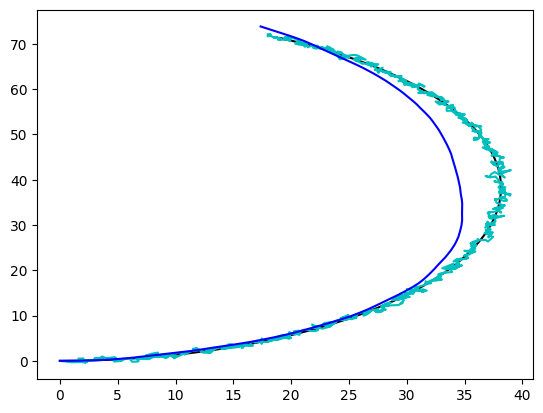

In [11]:
plt.cla()
plt.plot(xs, ys, color='k')
plt.plot(ekf_corrected_xs, ekf_corrected_ys, color='c')
plt.plot(no_filter_xs, no_filter_ys, color = 'b')

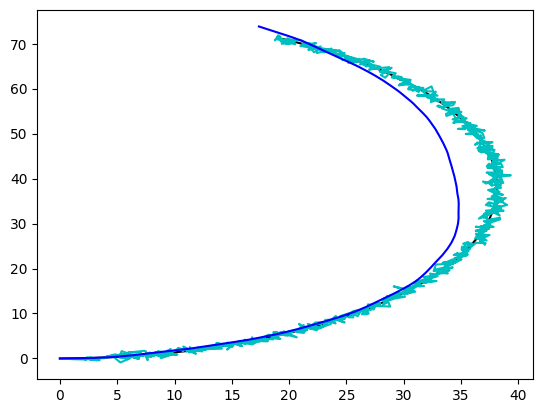

In [12]:
plt.cla()
plt.plot(xs, ys, color='k')
plt.plot(aekf_corrected_xs, aekf_corrected_ys, color='c')
plt.plot(no_filter_xs, no_filter_ys, color = 'b')

In [13]:
get_avg_error(xs, ys, ekf_corrected_xs, ekf_corrected_ys)

1.2174041713314472

In [14]:
get_avg_error(xs, ys, aekf_corrected_xs, aekf_corrected_ys)

0.6388248237404882

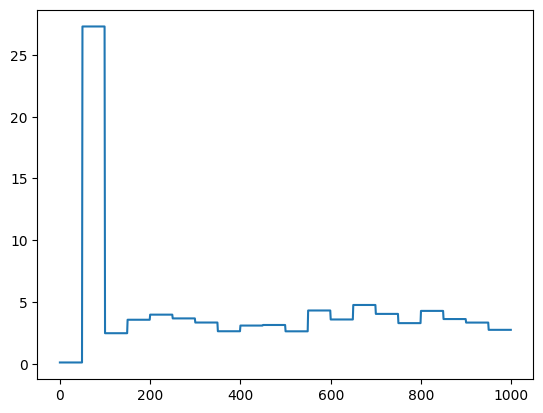

In [15]:
plt.plot(sigmas)